In [1]:
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
import warnings

d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip','c065c0e2593b8b161a2d7873e42418bf6a21106c')
data_dir = d2l.download_extract('pokemon')
pokemon = torchvision.datasets.ImageFolder(data_dir)

trans = torchvision.transforms.Compose([torchvision.transforms.Resize((64, 64)),torchvision.transforms.ToTensor(),
                                        torchvision.transforms.Normalize(0.5,0.5)])
pokemon.transform = trans
data_iter = torch.utils.data.DataLoader(pokemon,batch_size=256,shuffle=True,num_workers=d2l.get_dataloader_workers()) 

In [2]:
def update_D(X, Z, D, G, loss, Dupdater):
    batch = X.shape[0]
    ones = torch.ones(batch, device=X.device)
    zeros = torch.zeros(batch, device=X.device)
    Dupdater.zero_grad()
    fake_X = G(Z)
    Y=D(X)
    Y1=D(fake_X.detach())
    loss_D = (loss(Y, ones.reshape(Y.shape)) +loss(Y1, zeros.reshape(Y1.shape))) / (2*batch)
    loss_D.backward()
    Dupdater.step()
    return loss_D.item()

def update_G(Z, D, G, loss, Gupdater):
    batch = Z.shape[0]
    ones = torch.ones(batch, device=Z.device)
    Gupdater.zero_grad()
    Y=D(G(Z))
    loss_G = loss(Y, ones.reshape(Y.shape))/batch
    loss_G.backward()
    Gupdater.step()
    return loss_G.item()

class seq(nn.Module):
    def __init__(self,*args):
        super().__init__()
        for idx,module in enumerate(args):
            self._modules[str(idx)]=module

    def forward(self, X):
        for block in self._modules.values():
            X=block(X)
        return X
    
G = nn.Sequential(
    seq(nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),nn.BatchNorm2d(512),
        nn.ReLU()),     # Output: (512, 4, 4)
    seq(nn.ConvTranspose2d(in_channels=512, out_channels=256,kernel_size=4, stride=2,padding=1,bias=False),nn.BatchNorm2d(256),
        nn.ReLU()),     # Output: (256, 8, 8)
    seq(nn.ConvTranspose2d(in_channels=256, out_channels=128,kernel_size=4, stride=2,padding=1,bias=False),nn.BatchNorm2d(128),
        nn.ReLU()),     # Output: (128, 16, 16)
    seq(nn.ConvTranspose2d(in_channels=128, out_channels=64,kernel_size=4, stride=2,padding=1,bias=False),nn.BatchNorm2d(64),
        nn.ReLU()),   # Output: (64, 32, 32)
    nn.ConvTranspose2d(in_channels=64, out_channels=3,kernel_size=4, stride=2, padding=1, bias=False),nn.Tanh())  # Output: (3, 64, 64)

D=nn.Sequential(
    seq(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),nn.BatchNorm2d(64),
        nn.LeakyReLU(negative_slope=0.2, inplace=True)),     # Output: (64, 32, 32)
    seq(nn.Conv2d(in_channels=64, out_channels=128,kernel_size=4, stride=2,padding=1,bias=False),nn.BatchNorm2d(128),
        nn.LeakyReLU(negative_slope=0.2, inplace=True)),     # Output: (128, 16, 16)
    seq(nn.Conv2d(in_channels=128, out_channels=256,kernel_size=4, stride=2,padding=1,bias=False),nn.BatchNorm2d(256),
        nn.LeakyReLU(negative_slope=0.2, inplace=True)),     # Output: (256, 8, 8)
    seq(nn.Conv2d(in_channels=256, out_channels=512,kernel_size=4, stride=2,padding=1,bias=False),nn.BatchNorm2d(512),
        nn.LeakyReLU(negative_slope=0.2, inplace=True)),   # Output: (512, 4, 4)
    nn.Conv2d(in_channels=512, out_channels=1,kernel_size=4, stride=1, padding=0, bias=False))  # Output: (1,1,1)

def train(D,G,data_iter,epochs,device=d2l.try_gpu()):
    D, G = D.to(device), G.to(device)
    for w in D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in G.parameters():
        nn.init.normal_(w, 0, 0.02)
    Gupdater=torch.optim.Adam(G.parameters(),lr=0.005, betas=(0.5, 0.999))
    Dupdater=torch.optim.Adam(D.parameters(),lr=0.005, betas=(0.5, 0.999))
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',xlim=[1, epochs], nrows=2, figsize=(10, 10),legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for epoch in range(1, epochs + 1):
        timer = d2l.Timer()
        metric = d2l.Accumulator(1)
        i=0
        loss_D=0
        loss_G=0
        for X, _ in data_iter:
            batch = X.shape[0]
            Z = torch.normal(0, 1, size=(batch,100, 1, 1))
            X, Z = X.to(device), Z.to(device)
            loss_D=loss_D+update_D(X, Z, D, G, loss, Dupdater)
            loss_G=loss_G+update_G(Z, D, G, loss, Gupdater)
            metric.add(batch)
            i=i+1
        animator.add(epoch, (loss_D/i,loss_G/i))
        Z = torch.normal(0, 1, size=(32, 100, 1, 1), device=device)
        fake_X = G(Z).permute(0, 2, 3, 1) / 2 + 0.5 
        for i in range(0,4):
            imgss=torch.cat([fake_X[i * 8 + j].cpu().detach() for j in range(0,8)], dim=1)
            if i==0:
                imgs=imgss
            else:imgs=torch.cat([imgs,imgss], dim=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
                 
    print(f'{metric[0] / timer.stop():.1f} examples/sec on {str(device)}'
         f' total time {timer.stop():.1f}')

88.0 examples/sec on cuda:0 total time 461.4


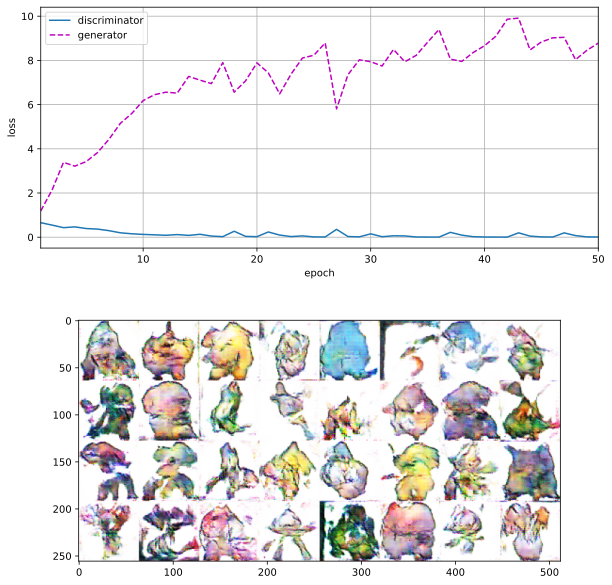

In [3]:
train(D, G, data_iter, 50) #epochs:50

In [ ]:
torch.save(net_D,'Dparams')
torch.save(net_G,'Gparams')
D_clone=torch.load('Dparams')
G_clone=torch.load('Gparams')
def train1(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    net_D, net_G = net_D.to(device), net_G.to(device)
    trainer_hp = {'lr': lr, 'betas': [0.5,0.999]}
    trainer_D = torch.optim.Adam(net_D.parameters(), **trainer_hp)
    trainer_G = torch.optim.Adam(net_G.parameters(), **trainer_hp)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X, Z = X.to(device), Z.to(device)
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, trainer_D),
                       d2l.update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Show generated examples
        Z = torch.normal(0, 1, size=(21, latent_dim, 1, 1), device=device)
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z).permute(0, 2, 3, 1) / 2 + 0.5
        imgs = torch.cat(
            [torch.cat([
                fake_x[i * 7 + j].cpu().detach() for j in range(7)], dim=1)
             for i in range(len(fake_x)//7)], dim=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')
    
latent_dim, lr, num_epochs = 100, 0.005, 50
train1(D_clone, G_clone, data_iter, num_epochs, lr, latent_dim)